In [1]:
import numpy as np
import ticktack
import jax.numpy as jnp
from jax import jit
from ticktack import fitting
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = (8.0, 4.0)

`fitting.fit_event` supports fitting all six known Miyake events via built-in datasets under `ticktack/src/data/datasets`. If one wants to use other datasets, put all data in .csv file of the same format as `example.csv`.


Example 1: Fit `775AD` Miyake event with `MCMC`.

In [2]:
mf, sampler = fitting.fit_event(775, 
                                '775AD', 
                                production_model="simple_sinusoid", 
                                sampler="MCMC", burnin=500, production=1000)

INFO[2021-11-30 15:19:03,746]: Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: 
INFO[2021-11-30 15:19:03,747]: Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2021-11-30 15:19:03,748]: Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
WARNING[2021-11-30 15:19:03,748]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Retrieving data...


100%|███████████████████████████████████████████████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


Running burn-in...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [02:13<00:00,  3.75it/s]


Running production...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:27<00:00,  3.74it/s]


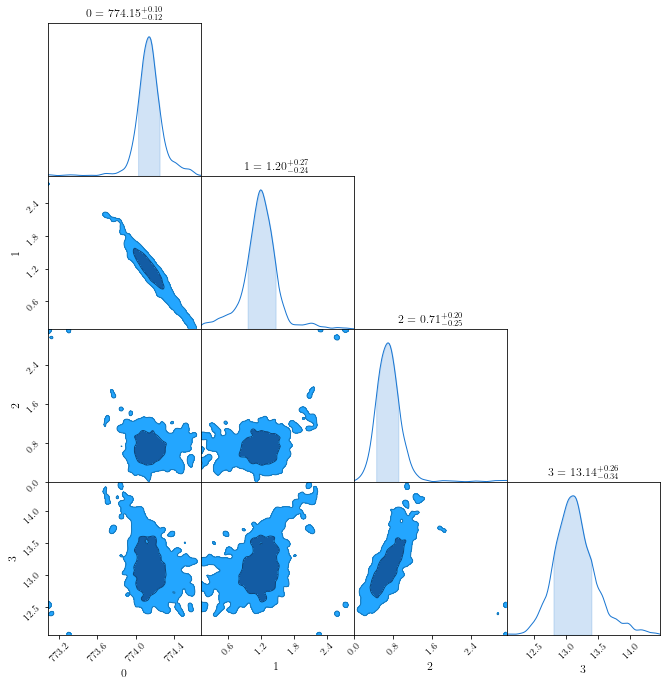

In [3]:
mf.chain_summary(sampler, 8)

Example 2: Fit `660BCE` Miyake event with `NS`. Instead of using built-in datasets, we will use `sakurai_Ew.csv` in `datasets` directory.

In [4]:
%%time
mf, sampler = fitting.fit_event(-660, 
                                path='datasets', 
                                production_model="simple_sinusoid", 
                                sampler="NS")

Retrieving data...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


Running Nested Sampling...
Done
CPU times: user 3min 5s, sys: 14.3 s, total: 3min 19s
Wall time: 3min 8s


Example 3: Fit `660BCE` Miyake event with `MCMC`. Instead of using built-in production models, we will use super gaussian pulse with flat production rate. Note that we need to specify the initial parameters and the bounds for the MCMC sampler

In [5]:
@jit
def super_gaussian(t, start_time, duration, area):
    middle = start_time + duration / 2.
    height = area / duration
    return height * jnp.exp(- ((t - middle) / (1. / 1.93516 * duration)) ** 16.)
@jit
def super_gaussian_pulse(t, *args):
    start_time, duration, area = jnp.array(list(args)).reshape(-1)
    height = super_gaussian(t, start_time, duration, area)
    production = 3.880300594380861 + height
    return production

In [6]:
mf, sampler = fitting.fit_event(-660, 
                                path='datasets', 
                                production_model=super_gaussian_pulse, 
                                params=jnp.array([-663.92695118, 1.34273951, 7.47358492]), 
                                sampler="MCMC", 
                                low_bounds=jnp.array([-669., 0., 0.]),
                                high_bounds=jnp.array([-650., 5., 15.]))

Retrieving data...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running burn-in...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 22.77it/s]


Running production...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.80it/s]


To visualise the fit,

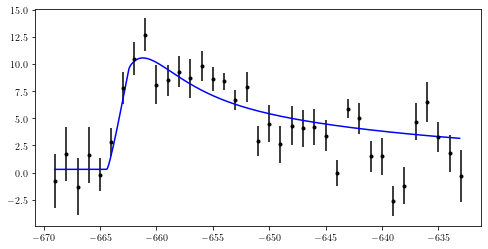

In [7]:
cbm = ticktack.load_presaved_model('Brehm21', production_rate_units = 'atoms/cm^2/s')
sf = fitting.SingleFitter(cbm)
sf.load_data('sakurai_Ew.csv')
sf.prepare_function(model=super_gaussian_pulse)
plt.errorbar(sf.time_data, sf.d14c_data, fmt=".k", yerr=sf.d14c_data_error)
plt.plot(sf.time_grid_fine[:-1], sf.dc14_fine(np.mean(sampler, axis=0)), "b", )